# K-MHaS (Korean Multi-label Hate Speech Dataset)

## Dataset loading

Loading the K-MHaS dataset from [HuggingFace](https://huggingface.co/datasets/jeanlee/kmhas_korean_hate_speech) and checking meta information (published @COLING2022)


In [1]:
!pip install emoji
!pip install transformers
!pip install datasets
!pip install keras_preprocessing
!pip install soynlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 11.3 MB/s eta 0:00:0000:01


In [2]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer

from soynlp.normalizer import repeat_normalize
import pandas as pd
import numpy as np
import random
import time
import datetime
from tqdm import tqdm

import emoji
import re
import csv
import os



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from datasets import load_dataset

dataset = load_dataset("jeanlee/kmhas_korean_hate_speech")

Generating train split:   0%|          | 0/78977 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8776 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21939 [00:00<?, ? examples/s]

Dataset kmhas downloaded and prepared to /root/.cache/huggingface/datasets/jeanlee___kmhas/default/1.0.0/17406fbed45548c92e0795df0675e21fb2a09ceaa098bd5ff58c7fdc7f8a63d4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset_test = load_dataset("jeanlee/kmhas_korean_hate_speech", split="test")
dataset_train = load_dataset("jeanlee/kmhas_korean_hate_speech", split="train")
dataset_valid = load_dataset("jeanlee/kmhas_korean_hate_speech", split="validation")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 78977
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 8776
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 21939
    })
})

In [5]:
import pandas as pd

def dataset_to_df(dataset):

  text_list = []
  label_list = []
  for tmp_data in dataset:
    text_list.append(tmp_data['text'])
    label_list.append(tmp_data['label'])
  df = pd.DataFrame({
      'text':text_list ,
      'label': label_list
  })
  return df


In [6]:
test_df  = dataset_to_df(dataset_test)
train_df = dataset_to_df(dataset_train)
valid_df = dataset_to_df(dataset_valid)

all_df = pd.concat([test_df, valid_df, train_df], ignore_index=True)
all_df.head(15)

,text,label
0,그만큼 길예르모가 잘했다고 보면되겠지 기대되네 셰이프 오브 워터,[8]
1,"""1. 8넘의 문재앙""","[2, 3]"
2,"""문재인 정권의 내로남불은 타의 추종을 불허하네. 자한당 욕할거리도 없음.""",[2]
3,"""짱개들 지나간 곳은 폐허된다 ㅋㅋ""",[0]
4,곱창은 자갈치~~~~~,[8]
5,밥맛없게생겼냐,[1]
6,알고 보니 외국 국적? 또는 국가유공자?,[8]
7,"""중국 유학생, 중국인들 입국 금지시키고 그들을 위해 쓰여질 많은 세금을 줄여""",[8]
8,"""댓글 길게 쓴거보니 우리 도태한녀 화 많이 났넹 ㅋㅋ 우쭈쭈""","[0, 5]"
9,이미연 닮음,[8]


In [7]:
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def text_preprocess(text):
    
    text = text.lstrip('"')
    text = text.rstrip('"')
    text = pattern.sub(' ', text)
    text = emoji.replace_emoji(text, replace='') #emoji 삭제
    text = url_pattern.sub('', text)
    text = text.strip()
    text = repeat_normalize(text, num_repeats=2)
    
    return text

all_df['text'] = all_df['text'].apply(lambda x : text_preprocess(x))
all_df.head(15)

,text,label
0,그만큼 길예르모가 잘했다고 보면되겠지 기대되네 셰이프 오브 워터,[8]
1,1. 8넘의 문재앙,"[2, 3]"
2,문재인 정권의 내로남불은 타의 추종을 불허하네. 자한당 욕할거리도 없음.,[2]
3,짱개들 지나간 곳은 폐허된다 ㅋㅋ,[0]
4,곱창은 자갈치~~~~~,[8]
5,밥맛없게생겼냐,[1]
6,알고 보니 외국 국적? 또는 국가유공자?,[8]
7,"중국 유학생, 중국인들 입국 금지시키고 그들을 위해 쓰여질 많은 세금을 줄여",[8]
8,댓글 길게 쓴거보니 우리 도태한녀 화 많이 났넹 ㅋㅋ 우쭈쭈,"[0, 5]"
9,이미연 닮음,[8]


In [8]:
# print(len(all_df))
# # all_df = all_df[all_df['label'].apply(lambda x: len(x) == 1)]
# # all_df['label'] = all_df['label'].apply(lambda x : x[0])
# all_df.reset_index(drop=True, inplace=True)
# print(len(all_df))
# all_df.head(15)

## Data preparation

- Prepare data from train, validation, and test dataset
- Multi-label is converted to multi-label one hot encodding

      class_label:
        names:
          0: origin
          1: physical
          2: politics
          3: profanity
          4: age
          5: gender
          6: race
          7: religion
          8: not_hate_speech

In [9]:
label_list = all_df['label']
text_list = all_df['text']

all_sentences =  ['[CLS] '+ text + ' [SEP]' for text in text_list]
all_sentences[:10]

['[CLS] 그만큼 길예르모가 잘했다고 보면되겠지 기대되네 셰이프 오브 워터 [SEP]',
 '[CLS] 1. 8넘의 문재앙 [SEP]',
 '[CLS] 문재인 정권의 내로남불은 타의 추종을 불허하네. 자한당 욕할거리도 없음. [SEP]',
 '[CLS] 짱개들 지나간 곳은 폐허된다 ㅋㅋ [SEP]',
 '[CLS] 곱창은 자갈치~~~~~ [SEP]',
 '[CLS] 밥맛없게생겼냐 [SEP]',
 '[CLS] 알고 보니 외국 국적? 또는 국가유공자? [SEP]',
 '[CLS] 중국 유학생, 중국인들 입국 금지시키고 그들을 위해 쓰여질 많은 세금을 줄여 [SEP]',
 '[CLS] 댓글 길게 쓴거보니 우리 도태한녀 화 많이 났넹 ㅋㅋ 우쭈쭈 [SEP]',
 '[CLS] 이미연 닮음 [SEP]']

In [10]:
# Tokenizing : bert-base-multilingual-cased

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [11]:
# convert multi-label to multi-label binary (one hot encoding)
# [8] -> [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]

from sklearn.preprocessing import MultiLabelBinarizer

enc = MultiLabelBinarizer()

def multi_label(example):
    enc_label = enc.fit_transform(example)
    float_arr = np.vstack(enc_label[:]).astype(float)
    update_label = float_arr.tolist()
    return update_label

In [12]:
MAX_LEN = 128

def data_to_tensor (sentences, labels):
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post") 

  attention_masks = []

  for seq in input_ids:
      seq_mask = [float(i > 0) for i in seq]
      attention_masks.append(seq_mask)

  tensor_inputs = torch.tensor(input_ids)
  tensor_labels = torch.tensor(labels)
  tensor_masks = torch.tensor(attention_masks)

  return tensor_inputs, tensor_labels, tensor_masks


In [13]:
label_list = multi_label(label_list)
inputs, labels, masks = data_to_tensor(all_sentences, label_list)

In [14]:
num_labels = 9

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=num_labels, problem_type="multi_label_classification",output_hidden_states=True)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [15]:
# load the saved model

path = '/kaggle/input/bermodel/BERT_model.pt'

model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [16]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model= model.to(device)
model.eval()

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [17]:
text = "[CLS] 파도처럼 부셔진 내맘 [SEP]"
encoded_input = tokenizer(text, return_tensors='pt').to(device)
output = model(**encoded_input)
output.hidden_states[-1].shape

torch.Size([1, 12, 768])

In [18]:
output.hidden_states[-1][:,0,:].shape

torch.Size([1, 768])

In [19]:
model.eval()

batch_size = 32

data = TensorDataset(inputs, masks, labels)
sampler = RandomSampler(data)
dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

In [20]:
# 임베딩을 저장할 리스트 초기화
embeddings = []

# 데이터 로더를 통해 배치 단위로 처리
for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        cls_hidden_state = outputs.hidden_states[-1].cpu()
        mean_embedding = torch.mean(cls_hidden_state,dim=1).squeeze()
        # BERT의 마지막 hidden layer에서 [CLS] 토큰의 hidden state 추출
        # 추출한 [CLS] 토큰의 hidden state를 임베딩 리스트에 추가
        embeddings.extend(mean_embedding)

# 이제 'embeddings' 리스트에는 모든 배치의 [CLS] 토

In [21]:
label_list = all_df['label']

## Prep for Pytorch

In [22]:
my_df = pd.DataFrame({
  "sentence" : embeddings,
  "label": label_list
})

In [23]:
my_df = my_df[my_df['label'].apply(lambda x: len(x) == 1)]

In [24]:
size = len(my_df)
matrix = np.zeros((size, 768))

In [25]:
my_df.reset_index(drop=True, inplace=True)
print(len(my_df))
my_df.head()

96085


,sentence,label
0,"[tensor(0.4242), tensor(-0.1857), tensor(0.124...",[8]
1,"[tensor(0.2963), tensor(0.5068), tensor(-0.394...",[2]
2,"[tensor(1.1459), tensor(-0.6443), tensor(-0.36...",[0]
3,"[tensor(0.7370), tensor(-0.5850), tensor(0.577...",[8]
4,"[tensor(-0.3011), tensor(0.4889), tensor(-1.50...",[1]


In [26]:
my_df['label'] = my_df['label'].apply(lambda x: x[0])
my_df.head()

,sentence,label
0,"[tensor(0.4242), tensor(-0.1857), tensor(0.124...",8
1,"[tensor(0.2963), tensor(0.5068), tensor(-0.394...",2
2,"[tensor(1.1459), tensor(-0.6443), tensor(-0.36...",0
3,"[tensor(0.7370), tensor(-0.5850), tensor(0.577...",8
4,"[tensor(-0.3011), tensor(0.4889), tensor(-1.50...",1


In [27]:
for idx, vectors in enumerate(my_df['sentence']):
    vector = np.array(vectors)
    matrix[idx] =vector 

class_list = my_df['label']

In [28]:
print(len(class_list))
print(matrix.shape)

96085
(96085, 768)


In [29]:
import re
import emoji
import numpy as np 
import pandas as  pd
import seaborn as sns
import sys, re, argparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import font_manager, rc

In [30]:
def visulize_sentences(title ,matrix, class_list, class_dict=None):
    
    vectors = matrix # 여기에 100차원 벡터 데이터를 입력하세요
    classes = class_list # 여기에 해당 벡터의 클래스 라벨(0에서 10 사이의 값)을 입력하세요
    
    if class_dict is not None:
        for idx, tmp_class in enumerate(classes):
            classes[idx] = class_dict[tmp_class]
        
    class_kind = len(set(classes))
    # t-SNE 임베딩 수행
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    vectors_tsne = tsne.fit_transform(vectors)

    # 시각화
    plt.figure(figsize=(20, 10))
    sns.scatterplot(
        x=vectors_tsne[:, 0], y=vectors_tsne[:, 1],
        hue=classes,
        palette=sns.color_palette("hsv", class_kind),
        legend="full",
        alpha=0.7
    )

    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')

In [32]:
# embeddings 메모리 해제 
import gc

del embeddings 
gc.collect()

19221

/tmp/ipykernel_32/2202868266.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes[idx] = class_dict[tmp_class]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 96085 samples in 0.052s...
[t-SNE] Computed neighbors for 96085 samples in 171.725s...
[t-SNE] Computed conditional probabilities for sample 7000 / 96085
[t-SNE] Computed conditional probabilities for sample 8000 / 96085
[t-SNE] Computed conditional probabilities for sample 9000 / 96085
[t-SNE] Computed conditional probabilities for sample 10000 / 96085
[t-SNE] Computed conditional probabilities for sample 11000 / 96085
[t-SNE] Computed conditional probabilities for sample 12000 / 96085
[t-SNE] Computed conditional probabilities for sample 13000 / 96085
[t-SNE] Computed conditional probabilities for sample 14000 / 96085
[t-SNE] Computed conditional probabilities for sample 15000 / 96085
[t-SNE] Computed conditional probabilities for sample 16000 / 96085
[t-SNE] Computed conditional probabilities for sample 17000 / 96085
[t-SNE] Computed conditional probabilities for sample 18000 / 96085
[t-SNE] Computed conditional probabilitie

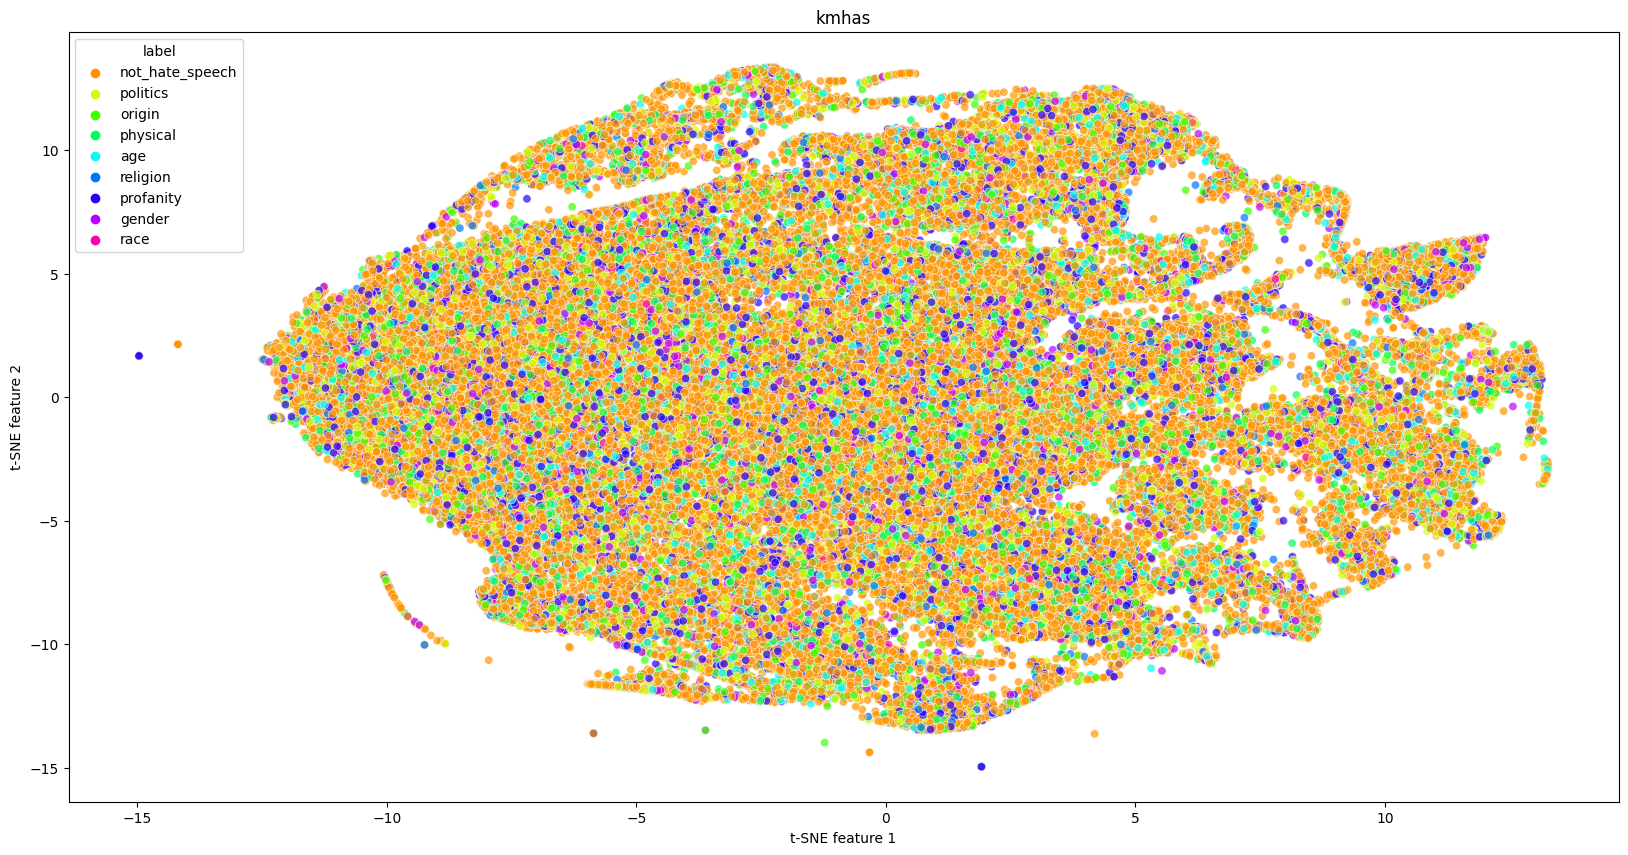

In [31]:
visulize_sentences("kmhas",matrix, class_list,{
    0: "origin", 1:"physical",2: "politics",3: "profanity",
    4: "age", 5:"gender", 6: "race", 7:"religion", 8:"not_hate_speech"
})